In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
                                     StratifiedKFold, cross_validate, cross_val_score, 
                                     ParameterGrid, GridSearchCV,  train_test_split
                                    )
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import (
                             accuracy_score, f1_score, recall_score, 
                             precision_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, 
                             roc_auc_score, roc_curve, auc
                            )

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder 
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
 


import joblib

import shap
import itertools



%matplotlib inline

In [1]:
def style_table(df, header_color='brown', font_size='10px', width='98%', show_head=10):
    """
    Уніфікована стилізація таблиці для pandas DataFrame.
    
    Parameters:
    - df: DataFrame для стилізації
    - header_color: Колір фону заголовка (default: 'brown')
    - font_size: Розмір шрифту (default: '10px')
    - width: Ширина таблиці (default: '98%')
    - show_head: Кількість рядків для показу (default: 10)
    
    Returns:
    - styled_df: Стилізований DataFrame
    """
    # Базові атрибути таблиці
    table_attrs = f'style="width: {width}; font-size: {font_size}; border-collapse: collapse;"'
    
    # Властивості для всіх комірок
    cell_props = {
        'background-color': 'white',
        'color': 'black',
        'border': '1px solid black',
        'text-align': 'center'
    }
    
    # Стилі для таблиці
    table_styles = [
        {
            'selector': 'th', 
            'props': [
                ('background-color', header_color), 
                ('color', 'white'), 
                ('font-weight', 'bold'), 
                ('text-align', 'center')
            ]
        },
        {
            'selector': 'td', 
            'props': [('text-align', 'center')]
        }
    ]
    
    # Застосування стилів
    styled_df = df.head(show_head).style \
        .set_table_attributes(table_attrs) \
        .set_properties(**cell_props) \
        .set_table_styles(table_styles)
    
    return styled_df

In [2]:
file_path = 'students_adaptability_level_online_education.csv'
try:  
    df = pd.read_csv(file_path)
    print("Дані успішно завантажені!")

    styled_df = style_table(df)

    display(styled_df)

except Exception as e:
    print("Помилка під час завантаження файлу:", e)

Помилка під час завантаження файлу: name 'pd' is not defined


# - Data processing

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [36]:
display(style_table(df.describe()))

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
count,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205
unique,2,6,3,2,2,2,2,3,2,3,3,2,3,3
top,Boy,21-25,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
freq,663,374,530,823,901,935,1004,878,695,775,840,995,1013,625


# Model

In [37]:

df['Adaptivity Level'] = df['Adaptivity Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

cat_cols = df.columns

for col in cat_cols[:-1]:
    df[col] = df[col].astype('category')
    df[col].cat.codes

display(style_table(df))

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,1
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,1
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,1
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,1
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,0
5,Boy,11-15,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,1-3,No,Mobile,0
6,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,0,No,Mobile,0
7,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,1
8,Boy,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,0
9,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,1


In [38]:
# X,y
X = df.drop('Adaptivity Level', axis=1)
y = df['Adaptivity Level']
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Adaptivity Level, dtype: int64

In [39]:
# Transformer: Label encode для cat
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols[:-1])
    ],
    remainder='passthrough')

base_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')

# Пайплайн з RF
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', base_clf)
])


In [40]:
# Fit на тренувальних зі стратифікацією
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('*'*30+' Report '+'*'*30, classification_report(y_test, y_pred), sep='\n\n')

****************************** Report ******************************

              precision    recall  f1-score   support

           0       0.93      0.92      0.92        96
           1       0.92      0.88      0.90       125
           2       0.67      0.90      0.77        20

    accuracy                           0.90       241
   macro avg       0.84      0.90      0.86       241
weighted avg       0.90      0.90      0.90       241



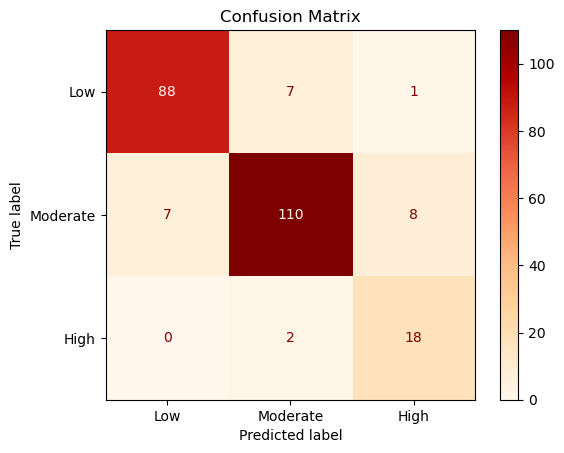

In [42]:
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Moderate', 'High'])
plt.figsize=(9,9)
disp.plot(cmap='OrRd', values_format='d')
plt.title('Confusion Matrix')
plt.show()


# Grid

In [43]:
# param_grid 
param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': [None, 'balanced_subsample', 'balanced']
}

# StratifiedKFold для CV (5 фолдів, stratify=y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV )
grid_search = GridSearchCV(
    pipeline, param_grid, 
    cv=skf, 
    scoring='f1_macro',  # Оптимізує macro F1 (баланс класів)
    n_jobs=-1,  
    verbose=1 
)

# Запуск (на повних X, y)
grid_search.fit(X, y)

# Найкращі параметри
print("Найкращі параметри:", grid_search.best_params_)
print("Найкращий macro F1:", grid_search.best_score_)

# Report на тестовому спліті з найкращою моделлю
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("\nClassification Report з найкращими параметрами:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High']))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Найкращі параметри: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Найкращий macro F1: 0.8897182351144896

Classification Report з найкращими параметрами:
              precision    recall  f1-score   support

         Low       0.93      0.94      0.93        96
    Moderate       0.93      0.91      0.92       125
        High       0.81      0.85      0.83        20

    accuracy                           0.92       241
   macro avg       0.89      0.90      0.89       241
weighted avg       0.92      0.92      0.92       241



In [44]:
cm_oh = confusion_matrix(y_pred=y_pred, y_true = y_test)

# CV+SMOTE for BASE CLF

In [45]:
smote = SMOTE(k_neighbors=2, random_state=42)

smote_pipeline = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('smote', smote),
                            ('classifier', base_clf)
])

In [46]:
# CV
def cv_with_smote(X, y, pipeline, n_splits=5):
    """Custom CV with smote"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = {
            'fold': [],
            'f1_macro': [],
            'f1_weighted': [],
            'precision': [],
            'recall': [],
            'class_0': [],
            'class_1': [],
            'class_2': []
    }
    
    print(f"\nЗапуск {n_splits}-fold Cross-Validation...")
    print("-" * 70)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
        y_train, y_test = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)
        
        # Тренування пайплайну (SMOTE застосується тільки на X_train!)
        pipeline.fit(X_train, y_train)
        
        # Передбачення на тесті
        y_pred = pipeline.predict(X_test)
        
        # Метрики
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Окремо для кожного класу
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        
        # Збираємо результати
        results['fold'].append(fold + 1)
        results['f1_macro'].append(f1_macro)
        results['f1_weighted'].append(f1_weighted)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['class_0'].append(report['0']['f1-score'])
        results['class_1'].append(report['1']['f1-score'])
        results['class_2'].append(report['2']['f1-score'])
        
        print(f"Фолд {fold + 1}: F1-macro={f1_macro:.3f}, F1-weighted={f1_weighted:.3f}, Recall={recall:.3f}")
    
    return pd.DataFrame(results)

In [47]:
cv_results = cv_with_smote(X, y, smote_pipeline, n_splits=5)


Запуск 5-fold Cross-Validation...
----------------------------------------------------------------------
Фолд 1: F1-macro=0.873, F1-weighted=0.902, Recall=0.900
Фолд 2: F1-macro=0.868, F1-weighted=0.909, Recall=0.905
Фолд 3: F1-macro=0.915, F1-weighted=0.948, Recall=0.946
Фолд 4: F1-macro=0.812, F1-weighted=0.856, Recall=0.851
Фолд 5: F1-macro=0.827, F1-weighted=0.853, Recall=0.851


In [48]:
print("\n" + "=" * 70)
print("РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ")
print("=" * 70)
print(cv_results.to_string(index=False))

print("\n" + "=" * 70)
print("СТАТИСТИКА")
print("=" * 70)
print(f"F1-macro:    {cv_results['f1_macro'].mean():.3f} ± {cv_results['f1_macro'].std():.3f}")
print(f"F1-weighted: {cv_results['f1_weighted'].mean():.3f} ± {cv_results['f1_weighted'].std():.3f}")
print(f"Precision:   {cv_results['precision'].mean():.3f} ± {cv_results['precision'].std():.3f}")
print(f"Recall:      {cv_results['recall'].mean():.3f} ± {cv_results['recall'].std():.3f}")

print(f"\nПо класам (F1-score):")
print(f"  Клас 0: {cv_results['class_0'].mean():.3f} ± {cv_results['class_0'].std():.3f}")
print(f"  Клас 1: {cv_results['class_1'].mean():.3f} ± {cv_results['class_1'].std():.3f}")
print(f"  Клас 2: {cv_results['class_2'].mean():.3f} ± {cv_results['class_2'].std():.3f}")


РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ
 fold  f1_macro  f1_weighted  precision   recall  class_0  class_1  class_2
    1  0.873034     0.901630   0.912159 0.900415 0.930000 0.897436 0.791667
    2  0.868283     0.908916   0.923114 0.904564 0.941799 0.908333 0.754717
    3  0.915243     0.947687   0.952036 0.946058 0.968421 0.951220 0.826087
    4  0.811527     0.856199   0.873054 0.850622 0.877005 0.866667 0.690909
    5  0.827071     0.853213   0.868151 0.850622 0.871795 0.854701 0.754717

СТАТИСТИКА
F1-macro:    0.859 ± 0.041
F1-weighted: 0.894 ± 0.040
Precision:   0.906 ± 0.035
Recall:      0.890 ± 0.041

По класам (F1-score):
  Клас 0: 0.918 ± 0.042
  Клас 1: 0.896 ± 0.038
  Клас 2: 0.764 ± 0.050


# RF with One-Hot Encoding

In [50]:
df_oh = df.copy()

In [51]:
le = LabelEncoder()
df_oh['Adaptivity Level'] = le.fit_transform(df_oh['Adaptivity Level'])  # 0=Low, 1=Moderate, 2=High

In [52]:
display(style_table(df_oh.head()))

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,1
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,1
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,1
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,1
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,0


In [53]:
X = df_oh.drop('Adaptivity Level', axis=1)
y = df_oh['Adaptivity Level']

X_oh = pd.get_dummies(X, dtype='float')
X_oh.head()

,Gender_Boy,Gender_Girl,Age_1-5,Age_11-15,Age_16-20,Age_21-25,Age_26-30,Age_6-10,Education Level_College,Education Level_School,...,Network Type_3G,Network Type_4G,Class Duration_0,Class Duration_1-3,Class Duration_3-6,Self Lms_No,Self Lms_Yes,Device_Computer,Device_Mobile,Device_Tab
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [54]:

X_train, X_test, y_train, y_test = train_test_split(X_oh, y, shuffle=True, stratify=y, test_size=0.2)

oh_rf_clf = RandomForestClassifier()
oh_rf_clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
# Передбачення
y_pred = oh_rf_clf.predict(X_test)

# Report
print("Classification Report для RF з one-hot:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High']))

# Importance (топ-10 фіч, тепер з one-hot)
importance = pd.DataFrame({
    'feature': X_oh.columns,
    'importance': oh_rf_clf.feature_importances_
}).sort_values('importance', ascending=False).head(10)
print("\nТоп-10 фіч за importance:")
print(importance)

Classification Report для RF з one-hot:
              precision    recall  f1-score   support

         Low       0.97      0.94      0.95        96
    Moderate       0.92      0.97      0.95       125
        High       0.88      0.75      0.81        20

    accuracy                           0.94       241
   macro avg       0.92      0.89      0.90       241
weighted avg       0.94      0.94      0.94       241


Топ-10 фіч за importance:
                        feature  importance
27             Class Duration_0    0.078092
0                    Gender_Boy    0.043735
1                   Gender_Girl    0.041408
19      Financial Condition_Mid    0.040908
11  Institution Type_Government    0.039821
29           Class Duration_3-6    0.038127
28           Class Duration_1-3    0.036417
23           Internet Type_Wifi    0.034648
21     Financial Condition_Rich    0.034166
26              Network Type_4G    0.033037


# CV+SMOTE for NEW CLF

In [56]:
new_clf = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)
smote_pipeline_new = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('smote', smote),
                            ('classifier', new_clf)
])
cv_results_new = cv_with_smote(X, y, smote_pipeline_new, n_splits=5)


Запуск 5-fold Cross-Validation...
----------------------------------------------------------------------
Фолд 1: F1-macro=0.873, F1-weighted=0.902, Recall=0.900
Фолд 2: F1-macro=0.868, F1-weighted=0.909, Recall=0.905
Фолд 3: F1-macro=0.912, F1-weighted=0.943, Recall=0.942
Фолд 4: F1-macro=0.818, F1-weighted=0.865, Recall=0.859
Фолд 5: F1-macro=0.827, F1-weighted=0.853, Recall=0.851


In [57]:
print("\n" + "=" * 70)
print("РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ ОНОВЛЕНОЇ МОДЕЛІ")
print("=" * 70)
print(cv_results_new.to_string(index=False))

print("\n" + "=" * 70)
print("СТАТИСТИКА")
print("=" * 70)
print(f"F1-macro:    {cv_results_new['f1_macro'].mean():.3f} ± {cv_results_new['f1_macro'].std():.3f}")
print(f"F1-weighted: {cv_results_new['f1_weighted'].mean():.3f} ± {cv_results_new['f1_weighted'].std():.3f}")
print(f"Precision:   {cv_results_new['precision'].mean():.3f} ± {cv_results_new['precision'].std():.3f}")
print(f"Recall:      {cv_results_new['recall'].mean():.3f} ± {cv_results_new['recall'].std():.3f}")

print(f"\nПо класам (F1-score):")
print(f"  Клас 0: {cv_results_new['class_0'].mean():.3f} ± {cv_results_new['class_0'].std():.3f}")
print(f"  Клас 1: {cv_results_new['class_1'].mean():.3f} ± {cv_results_new['class_1'].std():.3f}")
print(f"  Клас 2: {cv_results_new['class_2'].mean():.3f} ± {cv_results_new['class_2'].std():.3f}")


РЕЗУЛЬТАТИ КРОС-ВАЛІДАЦІЇ ОНОВЛЕНОЇ МОДЕЛІ
 fold  f1_macro  f1_weighted  precision   recall  class_0  class_1  class_2
    1  0.873034     0.901630   0.912159 0.900415 0.930000 0.897436 0.791667
    2  0.868283     0.908916   0.923114 0.904564 0.941799 0.908333 0.754717
    3  0.912107     0.943372   0.948044 0.941909 0.963731 0.946502 0.826087
    4  0.817916     0.864710   0.882204 0.858921 0.888889 0.873950 0.690909
    5  0.827071     0.853213   0.868151 0.850622 0.871795 0.854701 0.754717

СТАТИСТИКА
F1-macro:    0.860 ± 0.038
F1-weighted: 0.894 ± 0.036
Precision:   0.907 ± 0.032
Recall:      0.891 ± 0.037

По класам (F1-score):
  Клас 0: 0.919 ± 0.038
  Клас 1: 0.896 ± 0.035
  Клас 2: 0.764 ± 0.050


In [58]:
# Збереження пайплайну
joblib.dump(smote_pipeline_new, 'new_tuned_RF_model_with_smote.pkl')
print("\n✓ Модель збережена в 'new_tuned_RF_model_with_smote.pkl'")


✓ Модель збережена в 'new_tuned_RF_model_with_smote.pkl'


# XGB

In [59]:
# Pipeline для XGB
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'))  # XGB для мультикласу
])

# Параметри для XGB
param_grid_xgb = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__learning_rate': [0.05, 0.1, 0.2],  # Ключ для XGB
    'classifier__subsample': [0.8, 1.0],
    'classifier__min_child_weight': [1, 2, 4],  # Аналог min_samples_leaf
    'classifier__scale_pos_weight': [1, 2]  # Для дисбалансу (вага для High)
}

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV для XGB
grid_xgb = GridSearchCV(
    pipeline_xgb, param_grid_xgb, 
    cv=skf, scoring='f1_macro', 
    n_jobs=-1, verbose=1
)

# Запуск
grid_xgb.fit(X, y)

# Найкращі параметри
print("Найкращі параметри для XGB:", grid_xgb.best_params_)
print("Найкращий macro F1:", grid_xgb.best_score_)

# Report на тестовому спліті
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_xgb = grid_xgb.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
print("\nClassification Report для XGB:")
print(classification_report(y_test, y_pred_xgb, target_names=['Low', 'Moderate', 'High']))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:54:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Найкращі параметри для XGB: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}
Найкращий macro F1: 0.8935625116039085


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:54:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report для XGB:
              precision    recall  f1-score   support

         Low       0.93      0.92      0.92        96
    Moderate       0.91      0.91      0.91       125
        High       0.81      0.85      0.83        20

    accuracy                           0.91       241
   macro avg       0.88      0.89      0.89       241
weighted avg       0.91      0.91      0.91       241



# VotingModel

In [60]:
# Базові моделі (RF і XGB з тюнінгом)
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')
xgb_base = xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42, scale_pos_weight=2)

# Ансамбль
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base)
    ],
    voting='soft'  # 'hard' для голосування, 'soft' для ймовірностей (рекомендую)
)

# Pipeline для ансамблю
pipeline_ensemble = ImbPipeline([
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# Параметри для тюнінгу ансамблю (комбіновані)
param_grid_ensemble = {
    'ensemble__rf__n_estimators': [100, 300],
    'ensemble__rf__max_depth': [10, 20],
    'ensemble__xgb__n_estimators': [300, 500],
    'ensemble__xgb__max_depth': [10, 20],
    'ensemble__xgb__learning_rate': [0.05, 0.1]
}

# GridSearchCV для ансамблю
grid_ensemble = GridSearchCV(
    pipeline_ensemble, param_grid_ensemble, 
    cv=skf, scoring='f1_macro', 
    n_jobs=-1, verbose=1
)

# Запуск
grid_ensemble.fit(X, y)

# Найкращі параметри
print("Найкращі параметри для ансамблю:", grid_ensemble.best_params_)
print("Найкращий macro F1:", grid_ensemble.best_score_)

# Report на тесті
best_ensemble = grid_ensemble.best_estimator_
best_ensemble.fit(X_train, y_train)
y_pred_ens = best_ensemble.predict(X_test)
print("\nClassification Report для ансамблю:")
print(classification_report(y_test, y_pred_ens, target_names=['Low', 'Moderate', 'High']))

# Збереження
joblib.dump(best_ensemble, 'best_ensemble_model.pkl')

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:59:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Найкращі параметри для ансамблю: {'ensemble__rf__max_depth': 10, 'ensemble__rf__n_estimators': 300, 'ensemble__xgb__learning_rate': 0.1, 'ensemble__xgb__max_depth': 20, 'ensemble__xgb__n_estimators': 500}
Найкращий macro F1: 0.8887273606969144


C:\Users\oyuso\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:59:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report для ансамблю:
              precision    recall  f1-score   support

         Low       0.93      0.92      0.92        96
    Moderate       0.91      0.91      0.91       125
        High       0.81      0.85      0.83        20

    accuracy                           0.91       241
   macro avg       0.88      0.89      0.89       241
weighted avg       0.91      0.91      0.91       241



['best_ensemble_model.pkl']

In [61]:
# Витяг importance для RF
rf_clf = best_ensemble.named_steps['ensemble'].named_estimators_['rf']
rf_import = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Витяг importance для XGB
xgb_clf = best_ensemble.named_steps['ensemble'].named_estimators_['xgb']
xgb_import = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

# Вивід топ-10
print("RF Importance (топ-10):\n", rf_import.head(10))
print("\nXGB Importance (топ-10):\n", xgb_import.head(10))

RF Importance (топ-10):
                 feature  importance
7   Financial Condition    0.190314
10       Class Duration    0.141239
1                   Age    0.134412
0                Gender    0.077590
9          Network Type    0.066103
3      Institution Type    0.063892
2       Education Level    0.057723
5              Location    0.056790
8         Internet Type    0.048753
11             Self Lms    0.046307

XGB Importance (топ-10):
                 feature  importance
10       Class Duration    0.200703
5              Location    0.091198
7   Financial Condition    0.081006
11             Self Lms    0.077082
4            IT Student    0.074838
3      Institution Type    0.073733
1                   Age    0.072619
2       Education Level    0.062587
0                Gender    0.058832
9          Network Type    0.054189


In [62]:
rf_import.head(15)
#rf_import_features = rf_import.set_index('feature')
#rf_import_features.head()

,feature,importance
7,Financial Condition,0.190314
10,Class Duration,0.141239
1,Age,0.134412
0,Gender,0.077590
9,Network Type,0.066103
3,Institution Type,0.063892
2,Education Level,0.057723
5,Location,0.056790
8,Internet Type,0.048753
11,Self Lms,0.046307


In [63]:
xgb_import_features = xgb_import.set_index('feature')
xgb_import_features.head()

,importance
feature,
Class Duration,0.200703
Location,0.091198
Financial Condition,0.081006
Self Lms,0.077082
IT Student,0.074838


In [64]:
merged_df = pd.merge(rf_import, xgb_import, left_index=True, right_index=True, how='inner').sort_index().set_index('feature_x').drop('feature_y', axis=1)
merged_df.rename(columns={'importance_x': 'importance_rf', 'importance_y': 'importance_xgb'}, inplace=True)


In [65]:
merged_df = merged_df.sort_values(by='importance_rf', ascending=True)
merged_df.head()

,importance_rf,importance_xgb
feature_x,,
Load-shedding,0.036634,0.050520
IT Student,0.037920,0.074838
Device,0.042323,0.050002
Self Lms,0.046307,0.077082
Internet Type,0.048753,0.052692


In [66]:
plt.style.use('seaborn-v0_8-paper')

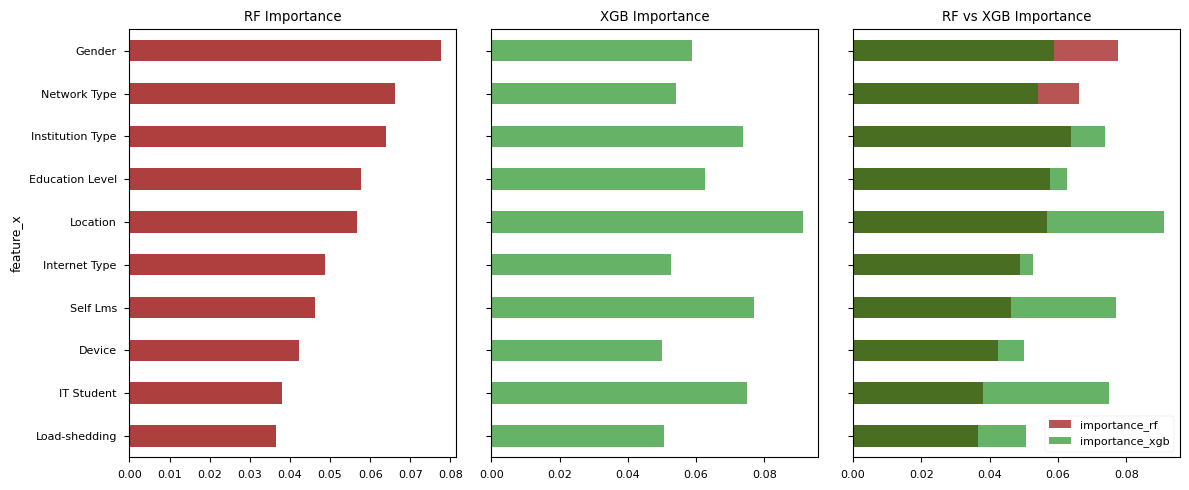

In [67]:
#Візуал

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
merged_df['importance_rf'].head(10).plot(kind='barh', ax=ax[0], title='RF Importance', color='brown', alpha=0.9)
merged_df['importance_xgb'].head(10).plot(kind='barh', ax=ax[1], title='XGB Importance', color='green', alpha=0.6)
merged_df['importance_rf'].head(10).plot(kind='barh', ax=ax[2], title='RF vs XGB Importance', color='brown', alpha=0.8)
merged_df['importance_xgb'].head(10).plot(kind='barh', ax=ax[2], color='green', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# Збереження пайплайну
joblib.dump(smote_pipeline_new, 'ensemble.pkl')
print("\n✓ Модель збережена в 'ensemble.pkl'")


✓ Модель збережена в 'ensemble.pkl'


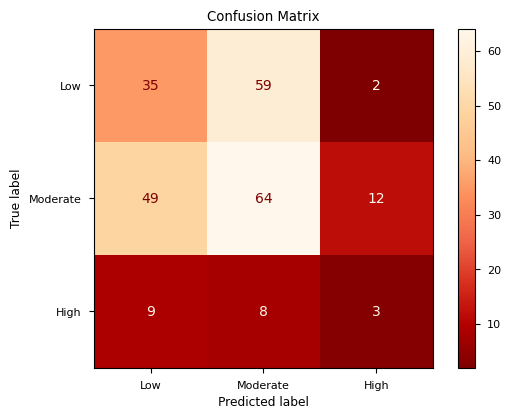

In [69]:
cm_voting = confusion_matrix(y_test, y_pred, labels=y_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm_voting, display_labels=['Low', 'Moderate', 'High'])
plt.figsize=(9,9)
disp.plot(cmap='OrRd_r', values_format='d')
plt.title('Confusion Matrix')
plt.show()


# Objective function

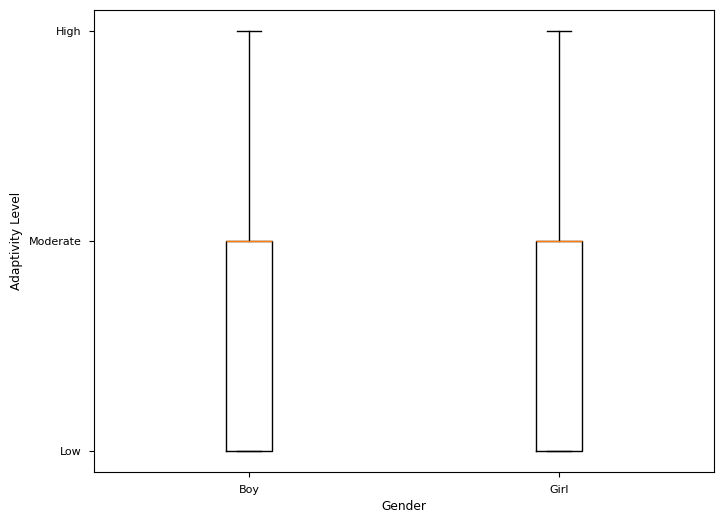

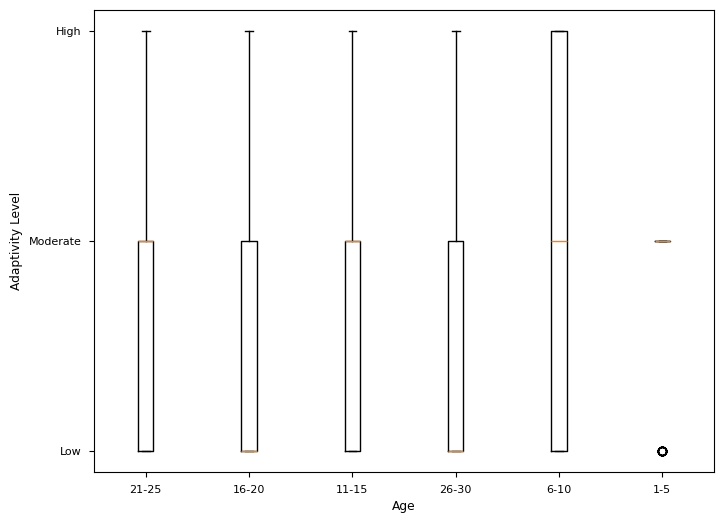

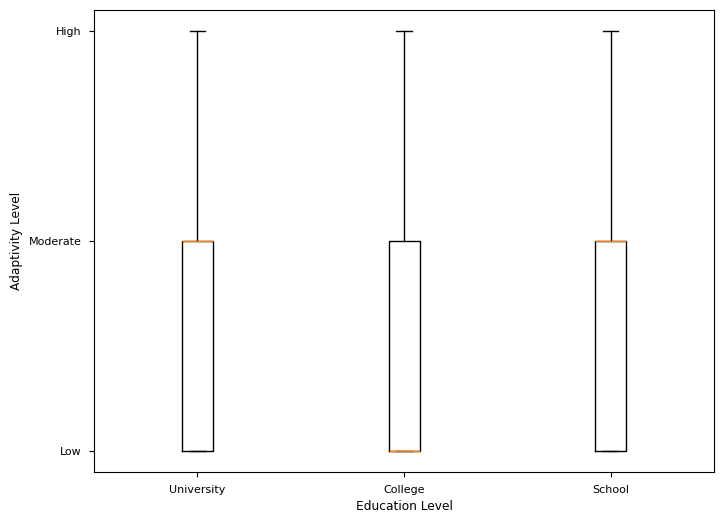

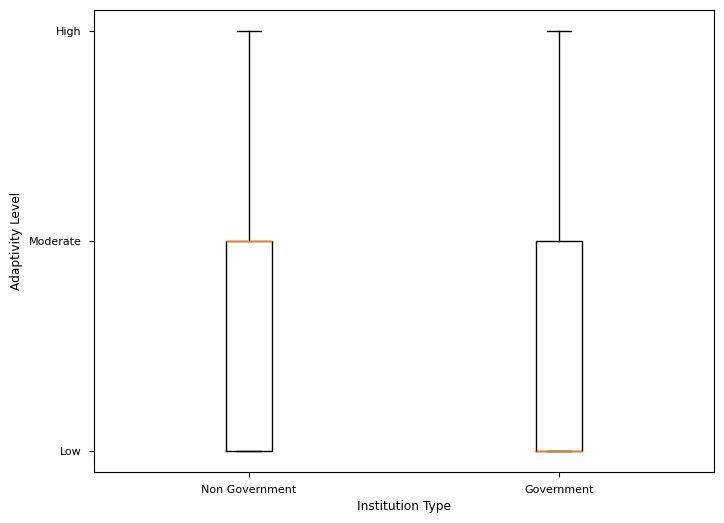

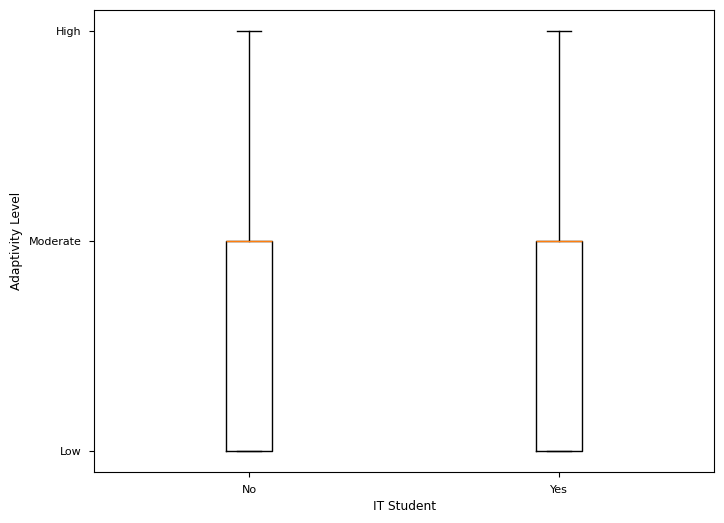

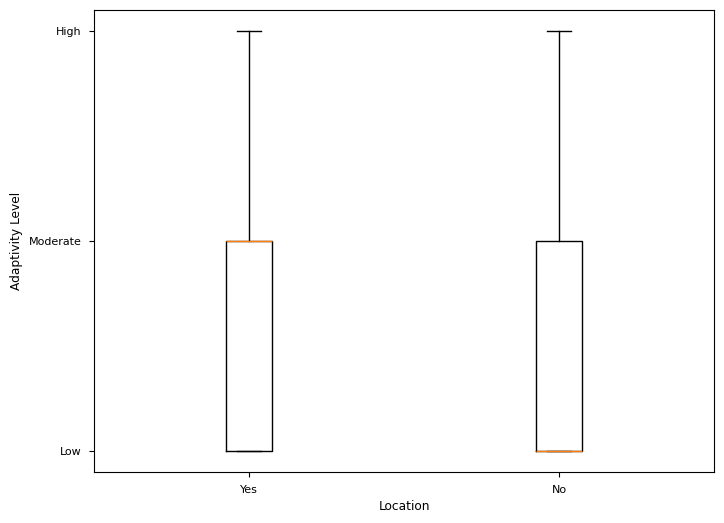

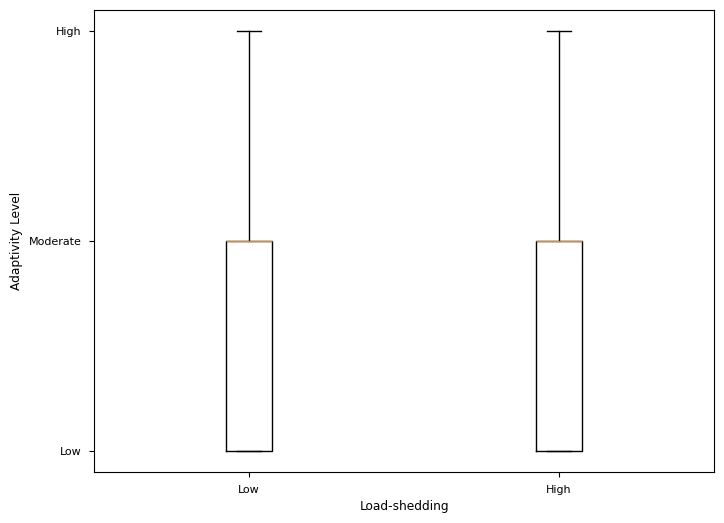

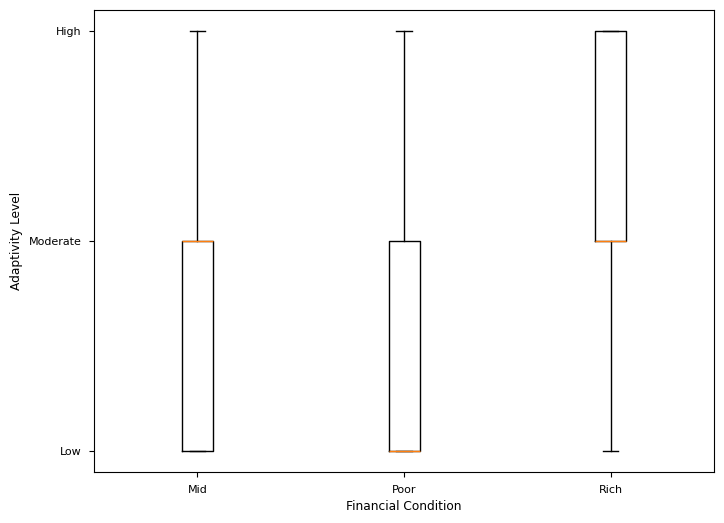

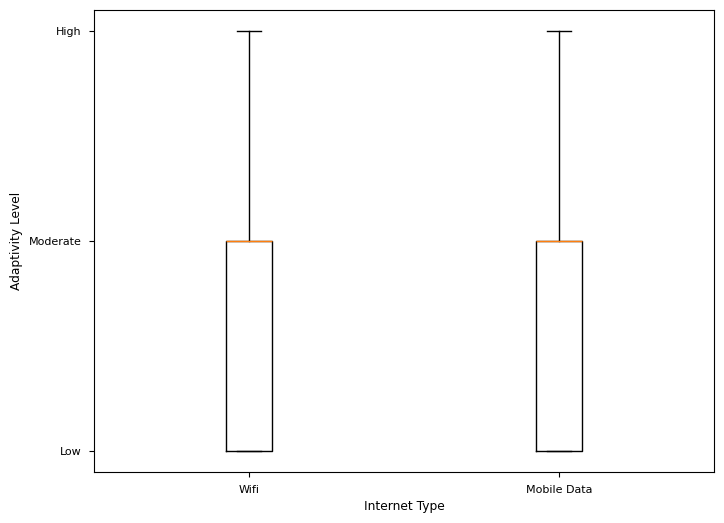

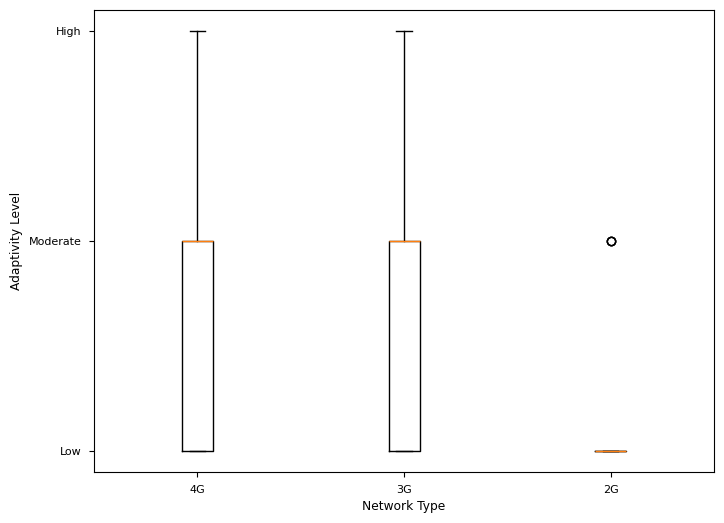

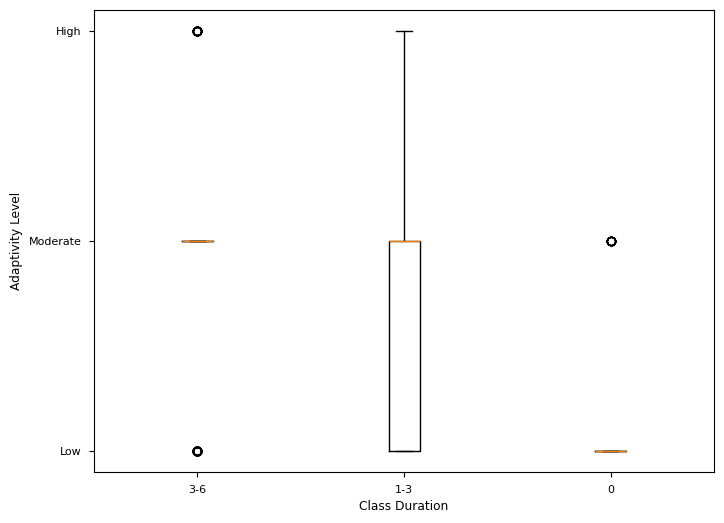

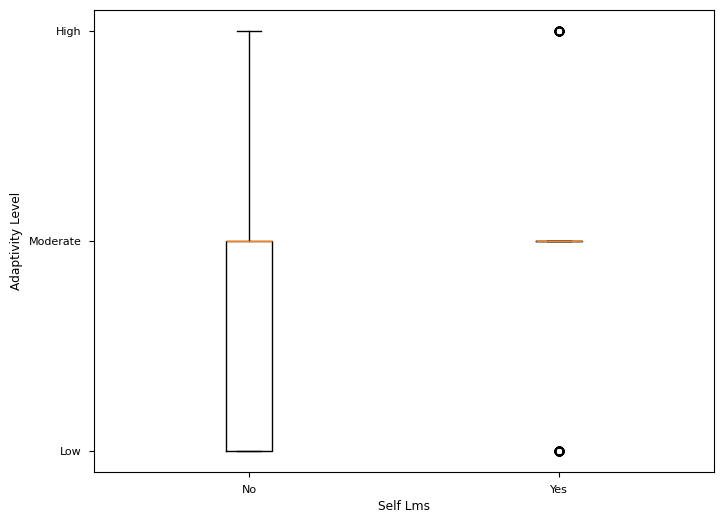

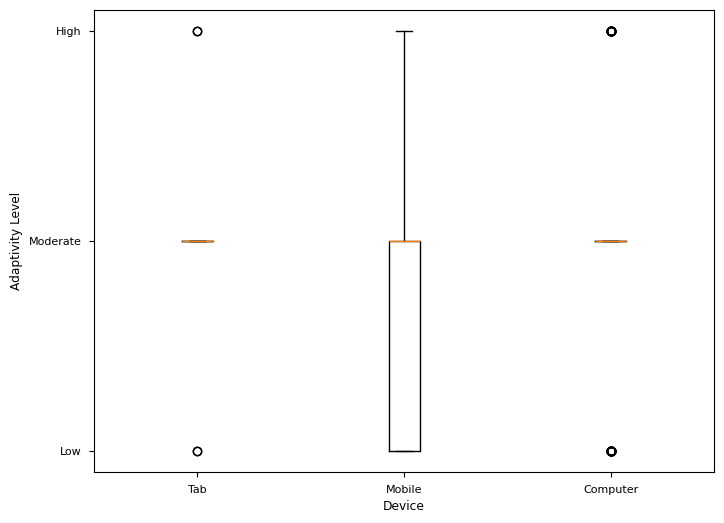

In [70]:
def boxplot(df, c):
    c_unique = df[c].unique()
    plt.figure(figsize=(8, 6))
    for i in range(len(c_unique)):
        plt.boxplot(df[df[c]==c_unique[i]]['Adaptivity Level'], positions=[i])
        plt.xticks(ticks=range(len(c_unique)), labels=c_unique)
        plt.yticks(ticks=[0,1,2], labels=['Low', 'Moderate', 'High'])
        plt.xlabel(str(c))
        plt.ylabel('Adaptivity Level')
        
for c in df.columns[:-1]:
    boxplot(df, c)

In [71]:
pipeline_rf = ImbPipeline([
                            ('preprocessor', preprocessor),
                            ('classifier', new_clf)               
                           ])

pipeline_rf.fit(X_train, y_train)

rf_best_model = pipeline_rf.named_steps['classifier']

X_test_transformed = pipeline_rf.named_steps['preprocessor'].transform(X_test)

explainer =  shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_test_transformed)

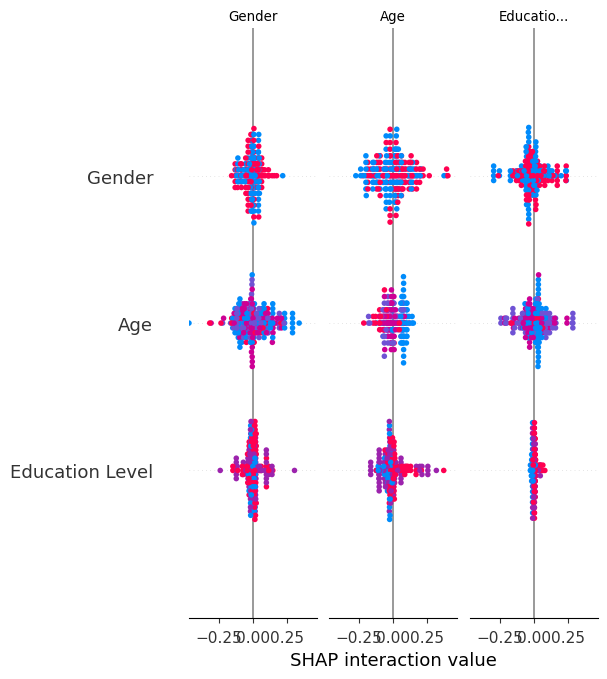

In [72]:
feature_names = list(map(lambda x: x.strip('cat_'), pipeline.named_steps['preprocessor'].get_feature_names_out()))

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, class_names=['Low', 'Moderate', 'High'])

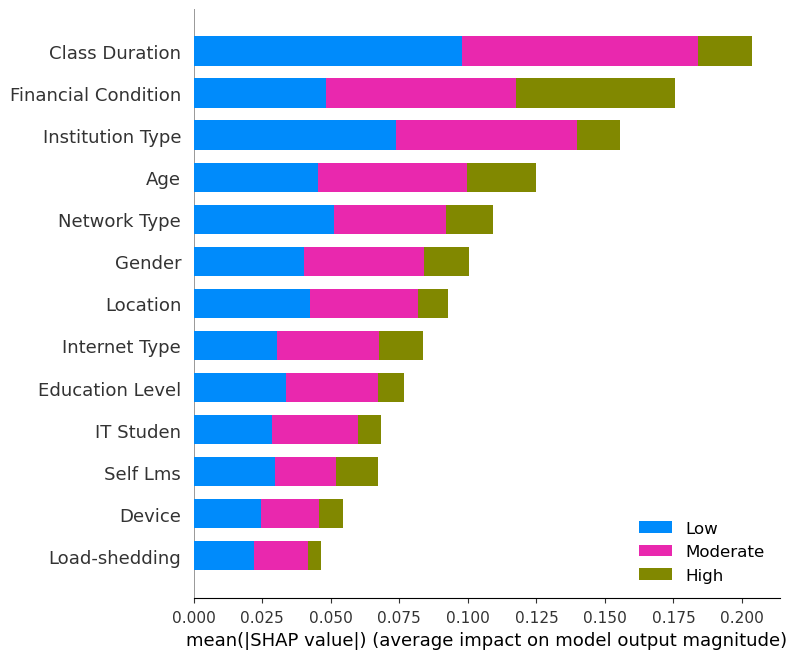

In [73]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type='bar', class_names=['Low', 'Moderate', 'High'])

In [74]:
# My optimization
w_j = np.abs(shap_values).mean(axis=0).mean(axis=1)
shap_importance = pd.DataFrame({'feature': feature_names, 'weight': w_j}).sort_values(by='weight', ascending=False)
shap_importance.set_index('feature', inplace=True)
style_table(shap_importance)

,weight
feature,
Class Duration,0.067893
Financial Condition,0.058459
Institution Type,0.051877
Age,0.041657
Network Type,0.036338
Gender,0.033522
Location,0.030894
Internet Type,0.027865
Education Level,0.025515


In [75]:
shap_importance['weight_scaled'] = shap_importance['weight'] / shap_importance['weight'].max()
style_table(shap_importance)

,weight,weight_scaled
feature,,
Class Duration,0.067893,1.000000
Financial Condition,0.058459,0.861046
Institution Type,0.051877,0.764100
Age,0.041657,0.613567
Network Type,0.036338,0.535221
Gender,0.033522,0.493747
Location,0.030894,0.455039
Internet Type,0.027865,0.410434
Education Level,0.025515,0.375816


таблиця масштабованих ваг для вибраних ознак


,weight,weight_scaled
feature,,
Class Duration,0.067893,1.000000
Network Type,0.036338,0.535221
Internet Type,0.027865,0.410434
Self Lms,0.022444,0.330586
Device,0.018165,0.267553


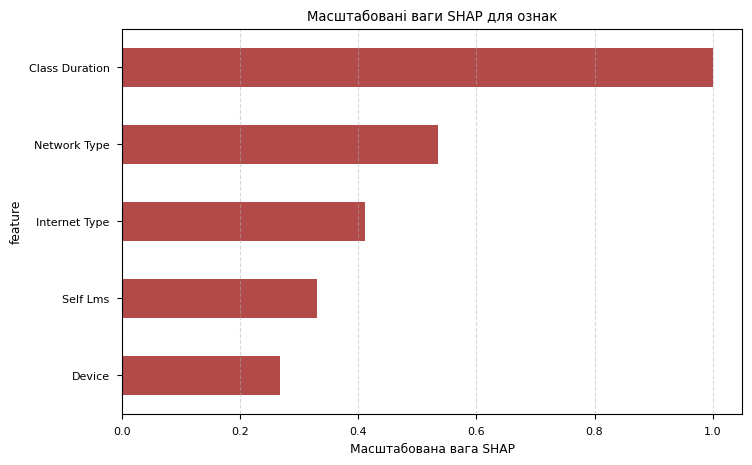

In [76]:
selected_features = ['Internet Type', 'Network Type', 'Class Duration', 'Self Lms', 'Device']
selected_shap_importance = shap_importance[shap_importance.index.isin(selected_features)]
print('таблиця масштабованих ваг для вибраних ознак')
display(style_table(selected_shap_importance))

fig, ax = plt.subplots(figsize=(8, 5))
selected_shap_importance.sort_values(by="weight_scaled", ascending=True).plot(
    kind="barh",
    y="weight_scaled",
    color="brown",
    legend=False,
    alpha=0.85,
    ax=ax
)
ax.set_xlabel("Масштабована вага SHAP")
ax.set_title("Масштабовані ваги SHAP для ознак")
ax.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()

In [77]:
# optimazation function components

def get_change_vector(x_original, x_new):
    return (x_original != x_new).astype(int)

def cost_weights(y_vec, shap_weights):
    return np.sum(y_vec * shap_weights)

def cost_basic(y_vec, alpha):
    return alpha * np.sum(y_vec)

def penalty_cost(x_new, rules_with_penalties):
    total_penalty = 0
    for rule_name, mask_fn, penalty_val in rules_with_penalties:
        if mask_fn(x_new):   # якщо комбінація є у векторі
            total_penalty += penalty_val
    return total_penalty

def total_cost(x_orig, x_new, shap_weights, alpha, rules_with_penalties):
    y_vec = get_change_vector(x_orig, x_new)
    cost1 = cost_basic(y_vec, alpha)
    cost2 = cost_weights(y_vec, shap_weights)
    cost3 = penalty_cost(x_new, rules_with_penalties)
    return cost1 + cost2 + cost3

In [78]:
df_penalty = df.copy()

df_penalty['Gender'] = df_penalty['Gender'].map({'Boy': 0, 'Girl': 1})
df_penalty['Age'] = df_penalty['Age'].map({'1-5': 0, '6-10': 1, '11-15': 2, '16-20': 3, '21-25': 4, '26-30': 5})
df_penalty['Education Level'] = df_penalty['Education Level'].map({'School': 0, 'College': 1, 'University': 2})
df_penalty['Institution Type'] = df_penalty['Institution Type'].map({'Government': 0, 'Non Government': 1})
df_penalty['IT Student'] = df_penalty['IT Student'].map({'No': 0, 'Yes': 1})
df_penalty['Location'] = df_penalty['Location'].map({'No': 0, 'Yes': 1})
df_penalty['Load-shedding'] = df_penalty['Load-shedding'].map({'Low': 0, 'High': 1})
df_penalty['Financial Condition'] = df_penalty['Financial Condition'].map({'Poor': 0, 'Mid': 1, 'Rich': 2})
df_penalty['Internet Type'] = df_penalty['Internet Type'].map({'Mobile Data': 0, 'Wifi': 1})
df_penalty['Network Type'] = df_penalty['Network Type'].map({'2G': 0, '3G': 1, '4G': 2})
df_penalty['Class Duration'] = df_penalty['Class Duration'].map({'0': 0, '1-3': 1, '3-6': 2})
df_penalty['Self Lms'] = df_penalty['Self Lms'].map({'No': 0, 'Yes': 1})
df_penalty['Device'] = df_penalty['Device'].map({'Mobile': 0, 'Tab': 1, 'Computer': 2})
df_penalty['Adaptivity Level'] = df_penalty['Adaptivity Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})


rules = [
    ("Mobile Data ∧ Network=2G ∧ ClassDuration=3-6",
     (df_penalty['Internet Type'] == 0) & (df_penalty['Network Type'] == 0) & (df_penalty['Class Duration'] == 2)),
    ("ClassDuration=3-6 ∧ Device=Mobile",
     (df_penalty['Class Duration'] == 2) & (df_penalty['Device'] == 0)),
    ("ClassDuration=0 ∧ Self LMS=Yes",
     (df_penalty['Class Duration'] == 0) & (df_penalty['Self Lms'] == 1)),
    ("ClassDuration=0 ∧ Device=Computer",
     (df_penalty['Class Duration'] == 0) & (df_penalty['Device'] == 2)),
    ("Device=Computer ∧ Mobile Data ∧ Network=2G",
     (df_penalty['Device'] == 2) & (df_penalty['Internet Type'] == 0) & (df_penalty['Network Type'] == 0)),
    ("Device=Tab ∧ Mobile Data ∧ Network=2G",
     (df_penalty['Device'] == 1) & (df_penalty['Internet Type'] == 0) & (df_penalty['Network Type'] == 0)),
    ("Financial=Poor ∧ Device=Computer",
     (df_penalty['Financial Condition'] == 0) & (df_penalty['Device'] == 2)),
    ("Load-shedding=High ∧ ClassDuration=3-6",
     (df_penalty['Load-shedding'] == 1) & (df_penalty['Class Duration'] == 2)),
    ("Device=Computer ∧ Load-shedding=High",
     (df_penalty['Device'] == 2) & (df_penalty['Load-shedding'] == 1)),
    ("IT Student=Yes ∧ Self LMS=No ∧ Class Duration=0",
     (df_penalty['IT Student'] == 1) & (df_penalty['Self Lms'] == 0) & (df_penalty['Class Duration'] == 0))
]
print(rules)
penalties = []
for desc, mask in rules:
    freq = mask.mean()
    print(freq)
    if freq == 0:
        penalty = float('inf')
    else:
        penalty = 1 - freq
    penalties.append((desc, round(freq * 100, 2), penalty))

result_df = pd.DataFrame(penalties, columns=["Умова", "Частота(%)", "Штраф"])


print("Таблиця з описом правил і штрафів:")
display(style_table(result_df))

saved_penalties = dict(zip(result_df["Умова"], result_df["Штраф"]))

[('Mobile Data ∧ Network=2G ∧ ClassDuration=3-6', 0       False
1       False
2       False
3       False
4       False
        ...  
1200    False
1201    False
1202    False
1203    False
1204    False
Length: 1205, dtype: bool), ('ClassDuration=3-6 ∧ Device=Mobile', 0       False
1       False
2       False
3       False
4       False
        ...  
1200    False
1201     True
1202    False
1203    False
1204    False
Length: 1205, dtype: bool), ('ClassDuration=0 ∧ Self LMS=Yes', 0       False
1       False
2       False
3       False
4       False
        ...  
1200    False
1201    False
1202    False
1203    False
1204    False
Length: 1205, dtype: bool), ('ClassDuration=0 ∧ Device=Computer', 0       False
1       False
2       False
3       False
4       False
        ...  
1200    False
1201    False
1202    False
1203    False
1204    False
Length: 1205, dtype: bool), ('Device=Computer ∧ Mobile Data ∧ Network=2G', 0       False
1       False
2       False
3       False
4       

,Умова,Частота(%),Штраф
0,Mobile Data ∧ Network=2G ∧ ClassDuration=3-6,0.000000,inf
1,ClassDuration=3-6 ∧ Device=Mobile,9.540000,0.904564
2,ClassDuration=0 ∧ Self LMS=Yes,0.170000,0.998340
3,ClassDuration=0 ∧ Device=Computer,0.500000,0.995021
4,Device=Computer ∧ Mobile Data ∧ Network=2G,0.000000,inf
5,Device=Tab ∧ Mobile Data ∧ Network=2G,0.000000,inf
6,Financial=Poor ∧ Device=Computer,1.410000,0.985892
7,Load-shedding=High ∧ ClassDuration=3-6,5.480000,0.945228
8,Device=Computer ∧ Load-shedding=High,2.740000,0.972614
9,IT Student=Yes ∧ Self LMS=No ∧ Class Duration=0,1.330000,0.986722
